# 1. Smoothing Techniques

## 1. Introduction
Smoothing Techniques are numerical methods which attempt to reduce variance or noise. A data set with a lot of noise has rough or jagged edges; removing this noise leaves a smoother line depicting the underlying pattern.

The term **filter** is sometimes used to describe a smoothing procedure. For instance, if the smoothed value for a particular time is calculated as a linear combination of observations for surrounding times, it might be said that we’ve applied a linear filter to the data (not the same as saying the result is a straight line, by the way).

https://online.stat.psu.edu/stat510/lesson/5/5.2

## 2. Types of Smoothing Techniques (filters)

1. Moving Average
2. Weighted Moving Average
3. Moving Median
4. Exponential Moving Average
5. Double Explonential Moving Average


Before we look at these smoothing techniques, lets load our data and have a look

In [2]:
# Import libraries to manipulate data
import pandas
import numpy 
import matplotlib.pyplot as pyplot

In [4]:
# Import the utilities module we wrote
import importlib.util
spec = importlib.util.spec_from_file_location("utilities", "../utilities.py")
utilities = importlib.util.module_from_spec(spec)
spec.loader.exec_module(utilities)

In [6]:
# Read the file into a dataframe
file_path = "../nasdaq_2019.csv"
converter_mapping = {
    "date": utilities.convert_date_string_to_date
}
pandas_dataframe = pandas.read_csv(file_path, converters=converter_mapping)

# Sort based on the date column
pandas_dataframe = pandas_dataframe.sort_values("date")

# Filter out data for a specific ticker
aaba_dataframe = pandas_dataframe.loc[pandas_dataframe.ticker == "AABA"]

# Filter down to the last month of data
# aaba_dataframe = aaba_dataframe.loc[aaba_dataframe["date"] > '2019-07-01']

# Remove unwanted columns
aaba_dataframe = aaba_dataframe[["date","open"]]

# Reset the index
aaba_dataframe.index = range(0, aaba_dataframe.shape[0])

# Show the first few rows
aaba_dataframe = aaba_dataframe

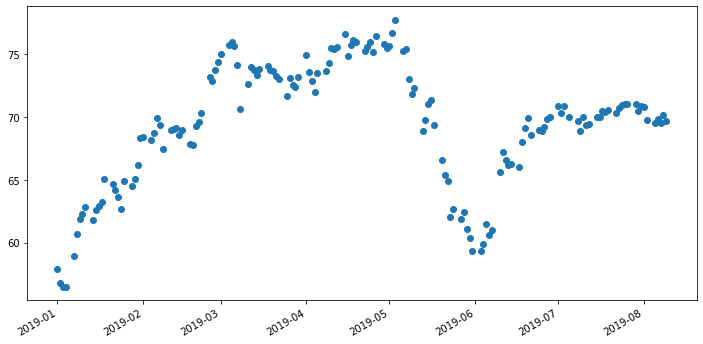

In [7]:
figure, axis = utilities.plot_dataframe(aaba_dataframe, "date", "open")

## 2.1 Moving Average

In [24]:
# We can use the built in pandas functionality to calculate the moving average
aaba_dataframe["ma3"] = aaba_dataframe["open"].rolling(window=3).mean()
aaba_dataframe["ma5"] = aaba_dataframe["open"].rolling(window=5).mean()
aaba_dataframe["ma10"] = aaba_dataframe["open"].rolling(window=10).mean()
aaba_dataframe["ma20"] = aaba_dataframe["open"].rolling(window=20).mean()

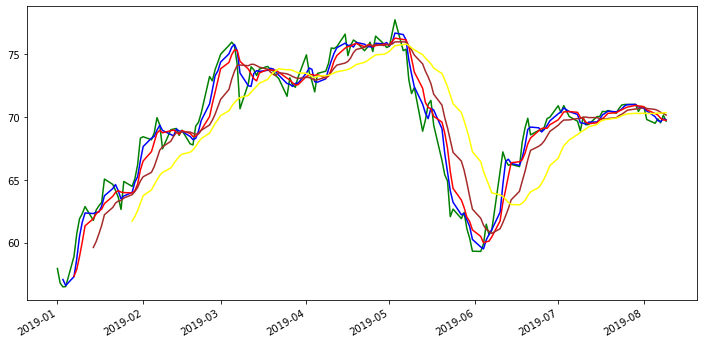

In [26]:
figure, axis = utilities.plot_dataframe(aaba_dataframe, "date", "open", scatter=False, line=True)
axis.plot(aaba_dataframe["date"], aaba_dataframe["ma3"], color="blue")
axis.plot(aaba_dataframe["date"], aaba_dataframe["ma5"], color="red")
axis.plot(aaba_dataframe["date"], aaba_dataframe["ma10"], color="brown")
axis.plot(aaba_dataframe["date"], aaba_dataframe["ma20"], color="yellow")

We can see that the line appears to track behind the actual data. In other words, the trend is shifted to the right. We can try to solve this using a weighted moving average. 

## 2.2 Weighted Moving Average
A weighted moving average places more emphasis on particular data points. We will use a larger weight for the more recent data points.

In [86]:
# Define the weights (oldest to newest)
# The number of weights needs to match the window for the average
w3 = numpy.array([.1, .2, .7])
w5 = numpy.array([0.05, .075, .175, .3, 0.4])
w10 = numpy.array([0.005, .0075, .0175, .03, 0.04, 0.05, .075, .175, .2, 0.4])

In [87]:
w10.sum()

1.0

In [88]:
# Define a function to calculate the weighted moving average given a set of terms and coresponding weights
# Note: the terms and the weights are provided oldest to newest
def weighted_moving_average(x, weights):  
    return (weights * x).sum().mean()


# We will create a function to pass to the Series.apply() function
# This function is expected to return a function 
# The function being returned which will accept a numpy array and return a number
def apply_function(weights):
    def helper_function(x):
        return weighted_moving_average(x, weights)
    return helper_function

In [89]:
aaba_dataframe["wma3"] = aaba_dataframe["open"].rolling(window=3).apply(apply_function(w3))
aaba_dataframe["wma5"] = aaba_dataframe["open"].rolling(window=5).apply(apply_function(w5))
aaba_dataframe["wma10"] = aaba_dataframe["open"].rolling(window=10).apply(apply_function(w10))

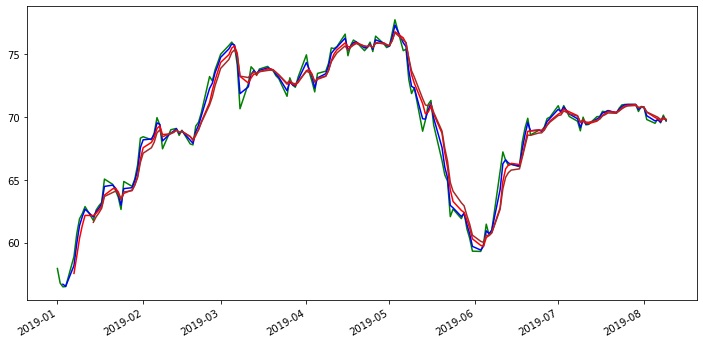

In [90]:
figure, axis = utilities.plot_dataframe(aaba_dataframe, "date", "open", scatter=False, line=True)
axis.plot(aaba_dataframe["date"], aaba_dataframe["wma3"], color="blue")
axis.plot(aaba_dataframe["date"], aaba_dataframe["wma5"], color="red")
axis.plot(aaba_dataframe["date"], aaba_dataframe["wma10"], color="brown")

We can see that the line is now smooth and tracking the real time data better than then vanilla moving average

## 2.2 Moving Median

In [92]:
# We can use the built in pandas functionality to calculate the moving average
aaba_dataframe["med3"] = aaba_dataframe["open"].rolling(window=3).median()
aaba_dataframe["med5"] = aaba_dataframe["open"].rolling(window=5).median()
aaba_dataframe["med10"] = aaba_dataframe["open"].rolling(window=10).median()
aaba_dataframe["med20"] = aaba_dataframe["open"].rolling(window=20).median()

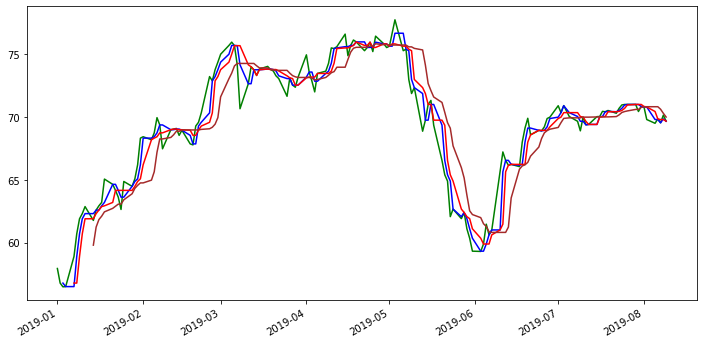

In [93]:
figure, axis = utilities.plot_dataframe(aaba_dataframe, "date", "open", scatter=False, line=True)
axis.plot(aaba_dataframe["date"], aaba_dataframe["med3"], color="blue")
axis.plot(aaba_dataframe["date"], aaba_dataframe["med5"], color="red")
axis.plot(aaba_dataframe["date"], aaba_dataframe["med10"], color="brown")

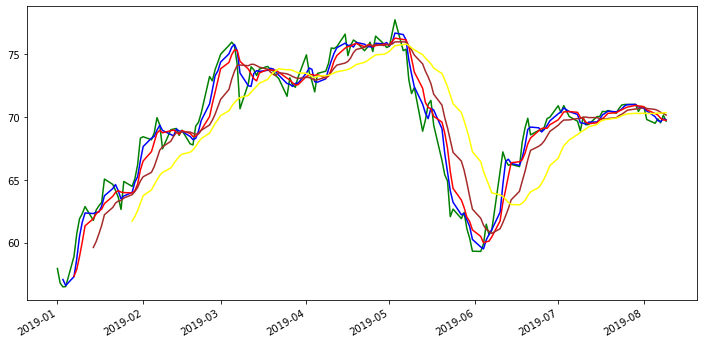

In [94]:
figure, axis = utilities.plot_dataframe(aaba_dataframe, "date", "open", scatter=False, line=True)
axis.plot(aaba_dataframe["date"], aaba_dataframe["ma3"], color="blue")
axis.plot(aaba_dataframe["date"], aaba_dataframe["ma5"], color="red")
axis.plot(aaba_dataframe["date"], aaba_dataframe["ma10"], color="brown")
axis.plot(aaba_dataframe["date"], aaba_dataframe["ma20"], color="yellow")

## 2.4 Exponential Moving Average

### An exponential moving average (EMA), also known as an exponentially weighted moving average (EWMA).

The EMA for a series X may be calculated recursively:

$
\begin{equation*}
    E_t = \begin{cases}
               X_1                                 & t = 0 \\
               \alpha X_t + (1 - \alpha)E_{t-1}    & t > 0
           \end{cases}
\end{equation*}
$

Where $\alpha$ represents the degree of weighting decrease, a constant smoothing factor between 0 and 1. A higher α discounts older observations faster.

https://en.wikipedia.org/wiki/Moving_average#Exponential_moving_average

In [96]:
# We can use the built in pandas functionality to calculate the moving average
aaba_dataframe["ema3"] = aaba_dataframe["open"].ewm(com=0.3).mean()
aaba_dataframe["ema5"] = aaba_dataframe["open"].ewm(com=0.5).mean()
aaba_dataframe["ema7"] = aaba_dataframe["open"].ewm(com=0.7).mean()
aaba_dataframe["ema9"] = aaba_dataframe["open"].ewm(com=0.9).mean()

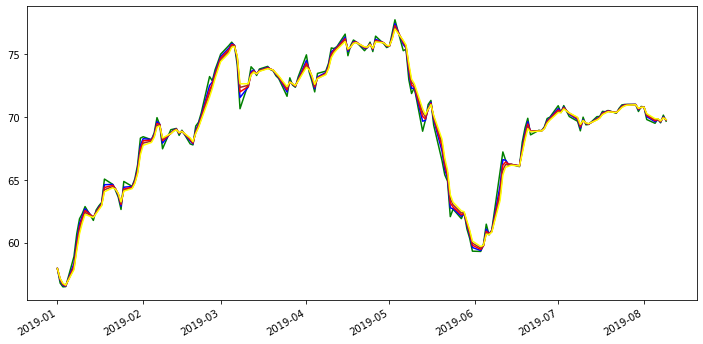

In [97]:
figure, axis = utilities.plot_dataframe(aaba_dataframe, "date", "open", scatter=False, line=True)
axis.plot(aaba_dataframe["date"], aaba_dataframe["ema3"], color="blue")
axis.plot(aaba_dataframe["date"], aaba_dataframe["ema5"], color="red")
axis.plot(aaba_dataframe["date"], aaba_dataframe["ema7"], color="brown")
axis.plot(aaba_dataframe["date"], aaba_dataframe["ema9"], color="yellow")

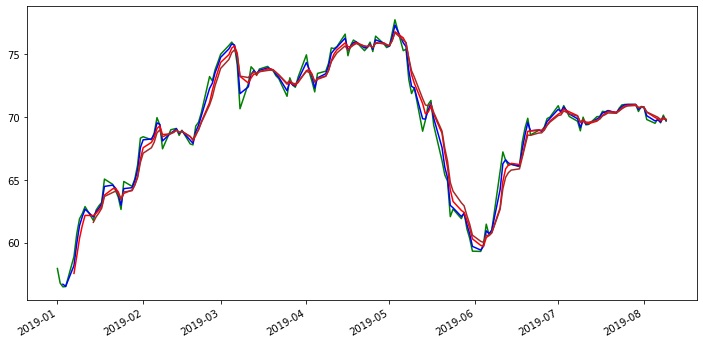

In [98]:
figure, axis = utilities.plot_dataframe(aaba_dataframe, "date", "open", scatter=False, line=True)
axis.plot(aaba_dataframe["date"], aaba_dataframe["wma3"], color="blue")
axis.plot(aaba_dataframe["date"], aaba_dataframe["wma5"], color="red")
axis.plot(aaba_dataframe["date"], aaba_dataframe["wma10"], color="brown")